# 루브릭

1. 시계열의 안정성이 충분히 확인되었는가?<br/>
  플로팅과 adfuller 메소드 사용으로 시계열의 안정성이 (충분히) 확인되는 것을 시각화하였으며, 이에 대한 충분한 설명(해당 메소드에 대한 이해)이 서술되어있음<br/><br/>
 
2. ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가?<br/>
  p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨<br/><br/>
 
3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?<br/>
  3개 이상 종목이 MAPE 15% 미만의 정확도로 예측됨<br/><br/>

## 삼성전자

In [3]:
!pip install statsmodels

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

dataset_filepath = os.getenv('HOME')+'/aiffel/project/Exploration/Samsung.csv' 
df = pd.read_csv(dataset_filepath) 
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-04-04,68900.0,69300.0,68600.0,69300.0,67983.734375,11107905
1,2022-04-05,69400.0,69600.0,69100.0,69200.0,67885.640625,8467248
2,2022-04-06,68600.0,68800.0,68500.0,68500.0,67198.921875,15517308
3,2022-04-07,68500.0,68500.0,68000.0,68000.0,66708.429688,20683327
4,2022-04-08,68100.0,68300.0,67700.0,67800.0,66512.226563,15453191


In [82]:
ts = df['Close']

ts.head()

0    69300.0
1    69200.0
2    68500.0
3    68000.0
4    67800.0
Name: Close, dtype: float64

In [83]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [84]:
# 로그 변환 시도 
ts_log = np.log(ts)

In [85]:
from statsmodels.tsa.stattools import adfuller

In [86]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

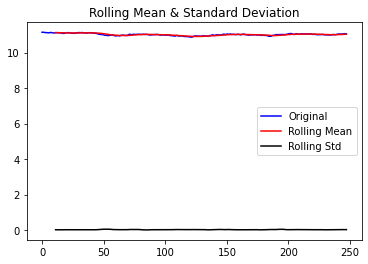

In [87]:
plot_rolling_statistics(ts_log, window=12)

In [88]:
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller메소드를 호출
    dftest = adfuller(timeseries, autolag='AIC')
    
    # adfuller메소드가 리턴한 결과를 정리하여 출력
    print('Results of Dickey-Fuller Test : ')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput[f'Critical Value {key}'] = value
    
    print(dfoutput)

In [89]:
#Time Series에 대한 Augmented Dickey-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test : 
Test Statistic                  -2.574549
p-value                          0.098372
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value 1%               -3.457105
Critical Value 5%               -2.873314
Critical Value 10%              -2.573044
dtype: float64


p-value가 0.09로 0.05이상이기에 대립가설이 채택되긴 어려워보임

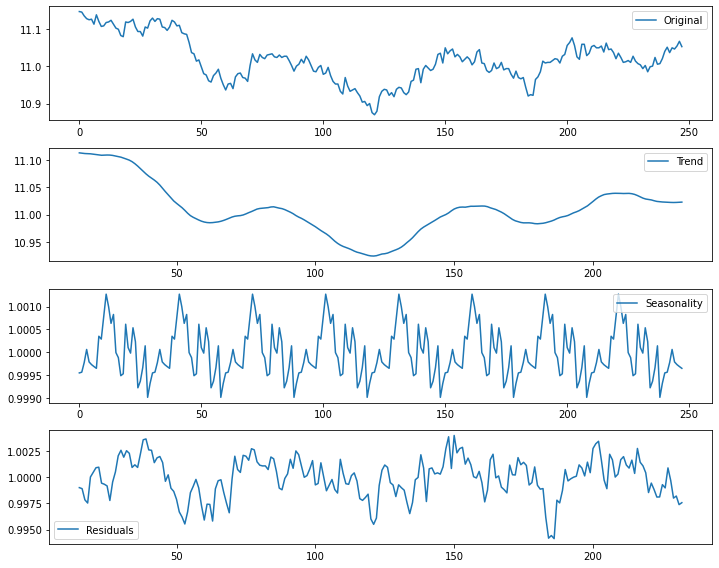

In [90]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10,8))
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [91]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test : 
Test Statistic                  -5.253788
p-value                          0.000007
#Lags Used                       0.000000
Number of Observations Used    217.000000
Critical Value 1%               -3.460849
Critical Value 5%               -2.874953
Critical Value 10%              -2.573919
dtype: float64


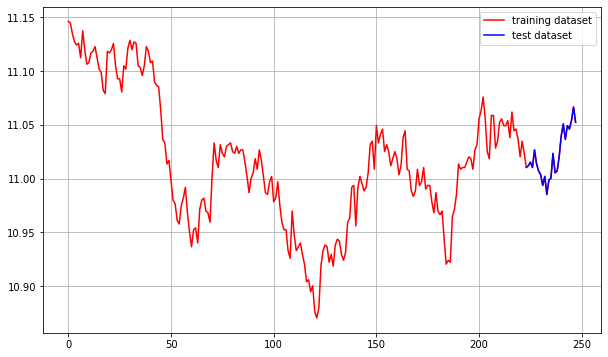

In [92]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### 자기상관함수(Autocorrelation Fucntion, ACF)]

먼저 ACF에 대해서 정리해보도록 하겠습니다. ACF는 y_t와 y_(t+k)사이에 correlation을 측정하는 것입니다. 

y_t와 y_(t+k)가 얼마나 관계가 있는지를 측정하는 것입니다.
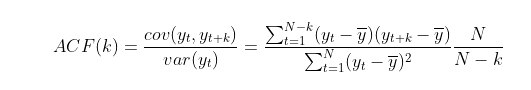

수식에서 확인할 수 있듯이 k가 커짐에 따라 ACF(k)값은 작아지게 됩니다. 추가적으로 ACF의 주요 성질로는 ACF(0)=1이며, ACF(k)=ACF(-k)입니다.


### [편자기상관함수(Partial Autocorrelation Fucntion, PACF)]

ACF는 분명히 활용성이 뛰어나고 중요한 Tool이긴 하지만 모든 시계열 데이터의 특성을 분석하는 것에는 한계가 있습니다. 시계열 모델 중에 대표적인 AR(q)모델이나 MA(p)모델중에 어떤 것을 활용하고 어떤 시차(lag)를 적용할지에 대해서 ACF를 활용하여 결정하는 것은 어렵습니다. 그렇기 때문에 PACF를 활용한 추가적인 분석이 필요합니다. 

PACF는 y_t와 y_(t+k)와의 correlation을 측정하는 것은 ACF와 동일하나, t와 t+k 사이에 다른 y값들의 영향력을 배제하고 측정하는 것입니다.
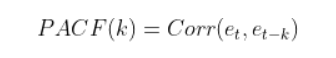

여기서 e_t는 아래와 같이 표현될 수 있습니다.
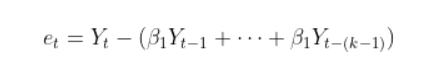

즉 e_t는 y_(t-k)를 제외하고 y_(t-1)에서 y_(t-(k-1)) 로 설명될 부분들을 제거한 것이고 e_(t-k)도 마찬가지로 볼 수 있습니다. 따라서 Corr(e_t, e_(t-1))을 계산한다는 것은 온전히 y_t와 y_(t+k)의 관계만 본다는 것입니다.

향후 AR, MA모델을 결정할떄 ACF와 PACF는 데이터 상황에 따라 다르겠지만 주로 아래와 같이 해석되어 활용될 수 있습니다.

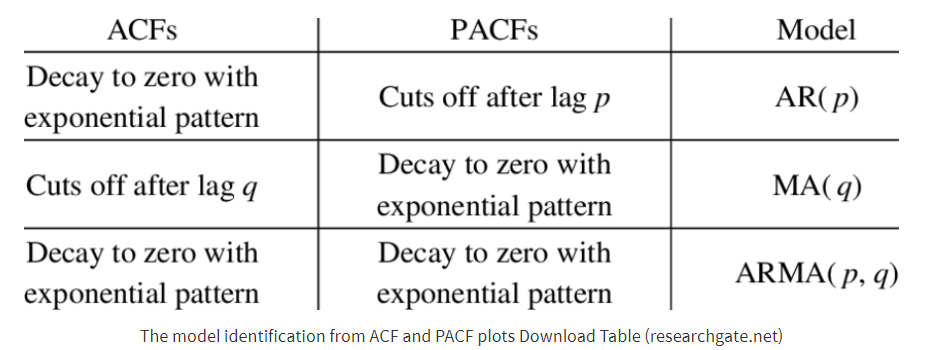

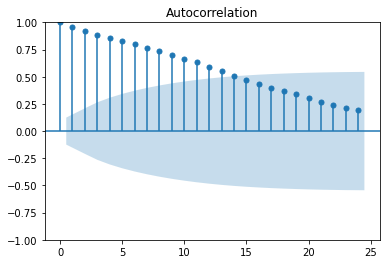

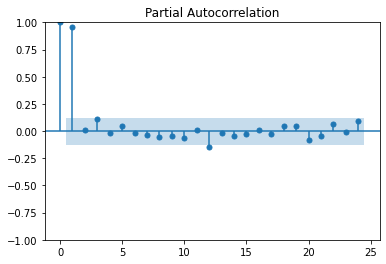

In [93]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

ACF는 점점 감소하고 있기에 q에 대한 정확한 값을 판단하기 어려워 보임 q=0<br/>
PACF는 p가 2이후로 0에 가까운 값에서 반복되고 있기에 p=2

Results of Dickey-Fuller Test : 
Test Statistic                -1.268435e+01
p-value                        1.168414e-23
#Lags Used                     1.000000e+00
Number of Observations Used    2.450000e+02
Critical Value 1%             -3.457326e+00
Critical Value 5%             -2.873410e+00
Critical Value 10%            -2.573096e+00
dtype: float64
Results of Dickey-Fuller Test : 
Test Statistic                -9.334608e+00
p-value                        9.133966e-16
#Lags Used                     9.000000e+00
Number of Observations Used    2.360000e+02
Critical Value 1%             -3.458366e+00
Critical Value 5%             -2.873866e+00
Critical Value 10%            -2.573339e+00
dtype: float64


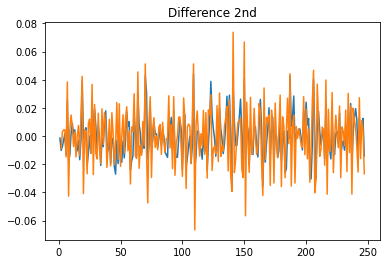

In [94]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

1차 차분으로 안정화 상태를 보인다고 판단 d=1

In [98]:
from statsmodels.tsa.arima.model import ARIMA
# ARIMA(p, d, q)
# Build Model
model = ARIMA(train_data, order=(2, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  223
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 612.845
Date:                Mon, 03 Apr 2023   AIC                          -1219.689
Time:                        13:54:34   BIC                          -1209.481
Sample:                             0   HQIC                         -1215.568
                                - 223                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0298      0.068     -0.441      0.659      -0.162       0.103
ar.L2         -0.1326      0.065     -2.029      0.042      -0.261      -0.004
sigma2         0.0002    2.2e-05     10.642      0.0

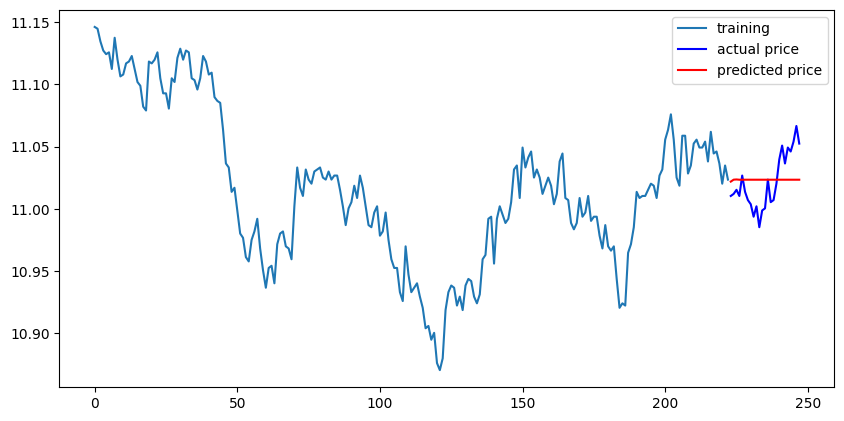

In [99]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [100]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1783019.484360965
MAE:  1167.8982262288396
RMSE:  1335.2975265314337
MAPE: 1.90%


MAPE 값 1.9%로 MAPE 15% 미만의 정확도 달성

## Nvidia

In [101]:
dataset_filepath = os.getenv('HOME')+'/aiffel/project/Exploration/NVDA.csv' 
df = pd.read_csv(dataset_filepath) 
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-04-04,267.279999,275.579987,266.130005,273.600006,273.344574,39712000
1,2022-04-05,272.540009,273.190002,258.200012,259.309998,259.067902,43661500
2,2022-04-06,249.339996,253.000000,240.029999,244.070007,243.842133,70383300
3,2022-04-07,244.410004,247.220001,234.779999,242.080002,241.853973,55799200
4,2022-04-08,239.169998,239.229996,230.619995,231.190002,230.974136,52478100


In [102]:
ts = df['Close']

ts.head()

0    273.600006
1    259.309998
2    244.070007
3    242.080002
4    231.190002
Name: Close, dtype: float64

In [103]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [104]:
# 로그 변환 시도 
ts_log = np.log(ts)

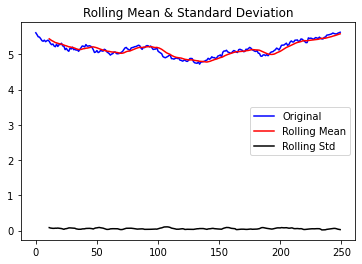

In [105]:
plot_rolling_statistics(ts_log, window=12)

In [106]:
#Time Series에 대한 Augmented Dickey-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test : 
Test Statistic                  -1.407135
p-value                          0.578851
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value 1%               -3.456888
Critical Value 5%               -2.873219
Critical Value 10%              -2.572994
dtype: float64


p-value가 0.5로 높은 값임을 확인

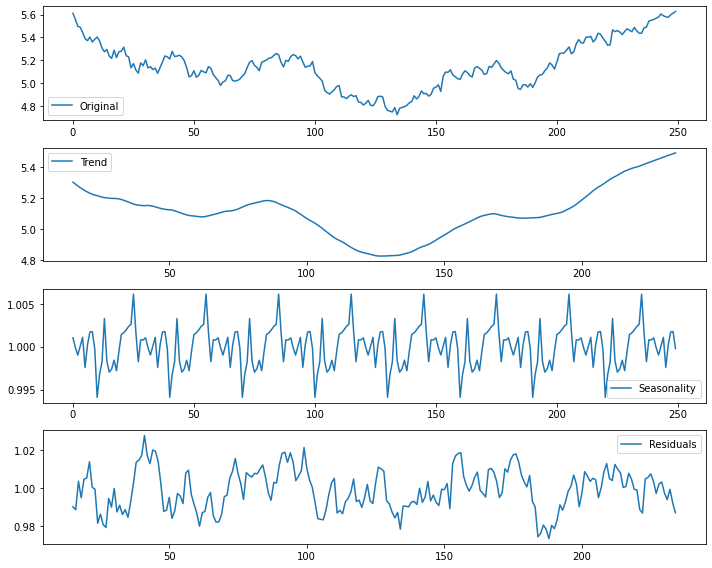

In [107]:
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10,8))
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [108]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test : 
Test Statistic                  -5.169289
p-value                          0.000010
#Lags Used                       1.000000
Number of Observations Used    218.000000
Critical Value 1%               -3.460708
Critical Value 5%               -2.874891
Critical Value 10%              -2.573886
dtype: float64


p-value값이 0.05 이하로 대립가설이 채택

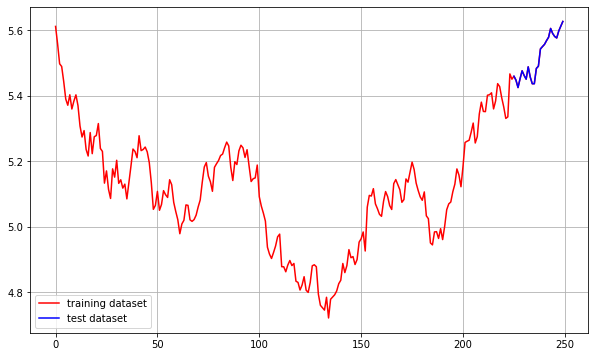

In [109]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

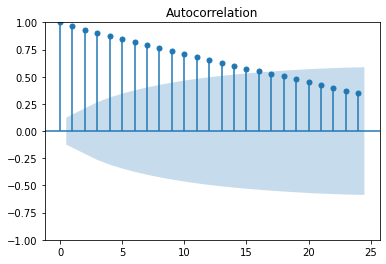

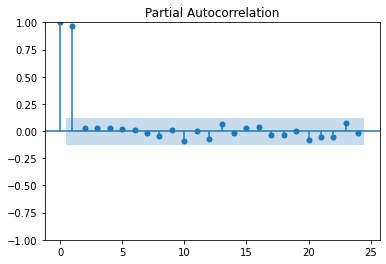

In [110]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

ACF는 점점 감소하고 있기에 q에 대한 정확한 값을 판단하기 어려워 보임 q=0<br/>
PACF는 p가 2이후로 0에 가까운 값에서 반복되고 있기에 p=2

Results of Dickey-Fuller Test : 
Test Statistic                -1.575150e+01
p-value                        1.221774e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value 1%             -3.456996e+00
Critical Value 5%             -2.873266e+00
Critical Value 10%            -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test : 
Test Statistic                -9.529298e+00
p-value                        2.919952e-16
#Lags Used                     9.000000e+00
Number of Observations Used    2.380000e+02
Critical Value 1%             -3.458128e+00
Critical Value 5%             -2.873762e+00
Critical Value 10%            -2.573283e+00
dtype: float64


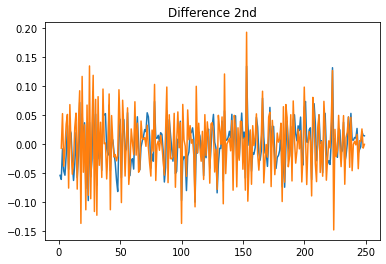

In [111]:
# 1차 차분
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 2차 차분
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

1차 차분으로도 안정성을 확인

In [112]:
model = ARIMA(train_data, order=(2, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 403.807
Date:                Mon, 03 Apr 2023   AIC                           -801.614
Time:                        13:59:40   BIC                           -791.380
Sample:                             0   HQIC                          -797.483
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0026      0.076     -0.034      0.973      -0.152       0.147
ar.L2      -2.745e-05      0.072     -0.000      1.000      -0.142       0.141
sigma2         0.0016      0.000     10.912      0.0

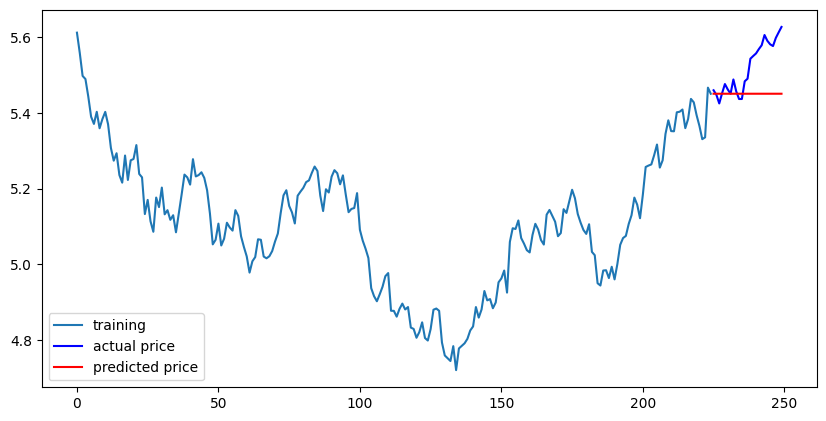

In [113]:
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

그래프로 확인하였을 땐 예측을 못한것 같이 보인다.

In [114]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  552.5026729172744
MAE:  17.848312108369395
RMSE:  23.50537540472975
MAPE: 6.79%


MAPE: 6.79%로 정확도 15%미만 

## 테슬라

In [115]:
dataset_filepath = os.getenv('HOME')+'/aiffel/project/Exploration/TSLA.csv' 
df = pd.read_csv(dataset_filepath) 
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-04-04,363.126678,383.303345,357.510010,381.816681,381.816681,82035900
1,2022-04-05,378.766663,384.290009,362.433319,363.753326,363.753326,80075100
2,2022-04-06,357.823334,359.666656,342.566681,348.586670,348.586670,89348400
3,2022-04-07,350.796661,358.863342,340.513336,352.420013,352.420013,79447200
4,2022-04-08,347.736664,349.480011,340.813324,341.829987,341.829987,55013700


In [116]:
ts = df['Close']

ts.head()

0    381.816681
1    363.753326
2    348.586670
3    352.420013
4    341.829987
Name: Close, dtype: float64

In [117]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [118]:
# 로그 변환 시도 
ts_log = np.log(ts)

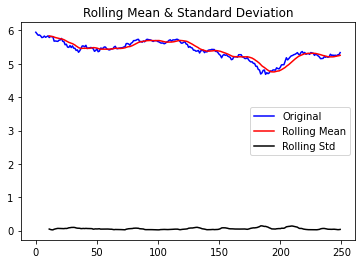

In [119]:
plot_rolling_statistics(ts_log, window=12)

In [120]:
#Time Series에 대한 Augmented Dickey-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test : 
Test Statistic                  -2.210680
p-value                          0.202392
#Lags Used                       9.000000
Number of Observations Used    240.000000
Critical Value 1%               -3.457894
Critical Value 5%               -2.873659
Critical Value 10%              -2.573229
dtype: float64


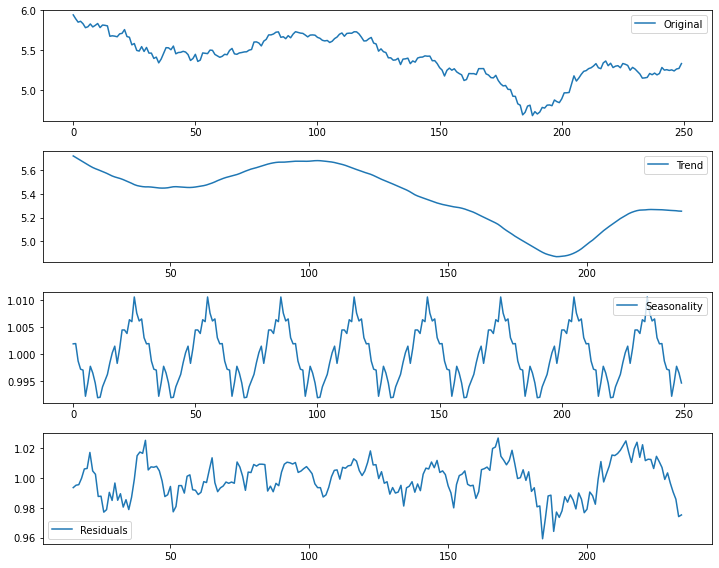

In [121]:
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10,8))
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [122]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test : 
Test Statistic                  -4.288323
p-value                          0.000465
#Lags Used                       9.000000
Number of Observations Used    210.000000
Critical Value 1%               -3.461879
Critical Value 5%               -2.875404
Critical Value 10%              -2.574159
dtype: float64


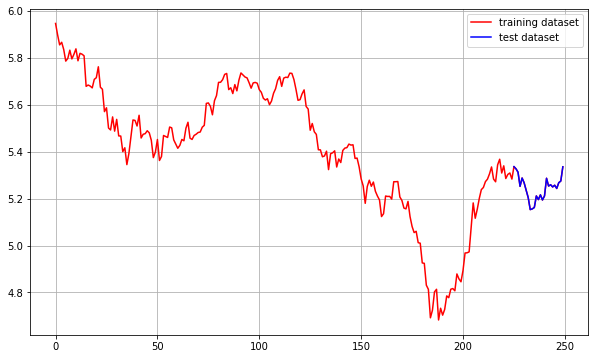

In [123]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

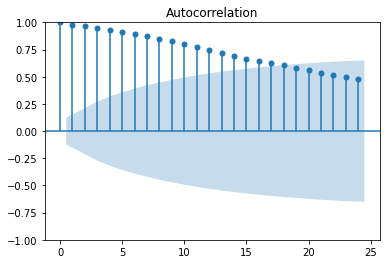

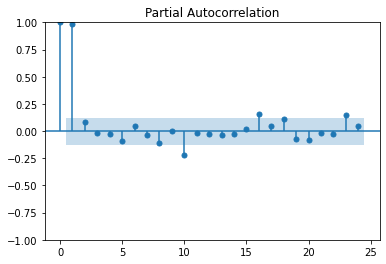

In [124]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

ACF는 점점 감소하고 있기에 q에 대한 정확한 값을 판단하기 어려워 보임 q=0<br/>
PACF는 p가 2이후로 0에 가까운 값에서 반복되고 있기에 p=2

Results of Dickey-Fuller Test : 
Test Statistic                  -3.446539
p-value                          0.009471
#Lags Used                       8.000000
Number of Observations Used    240.000000
Critical Value 1%               -3.457894
Critical Value 5%               -2.873659
Critical Value 10%              -2.573229
dtype: float64
Results of Dickey-Fuller Test : 
Test Statistic                -1.111837e+01
p-value                        3.516194e-20
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value 1%             -3.457894e+00
Critical Value 5%             -2.873659e+00
Critical Value 10%            -2.573229e+00
dtype: float64


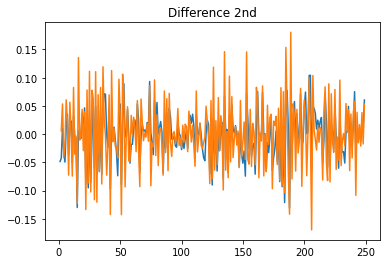

In [77]:
# 1차 차분
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 2차 차분
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [134]:
model = ARIMA(train_data, order=(2, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 386.991
Date:                Mon, 03 Apr 2023   AIC                           -767.982
Time:                        14:07:16   BIC                           -757.747
Sample:                             0   HQIC                          -763.851
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0683      0.076     -0.900      0.368      -0.217       0.080
ar.L2          0.0609      0.055      1.101      0.271      -0.047       0.169
sigma2         0.0018      0.000     11.544      0.0

p값 20으로 테스트 해봤다.

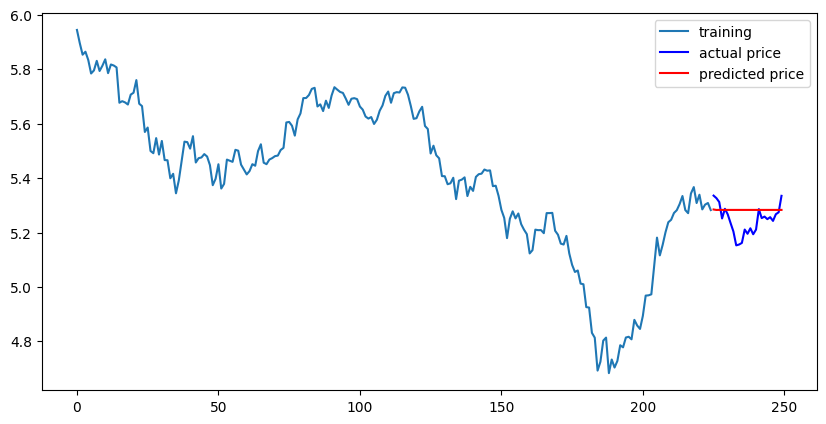

In [135]:
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [136]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  145.05127509066068
MAE:  9.962799582725188
RMSE:  12.04372347285758
MAPE: 5.40%


p = 20 -> MAPE: 3.96%로 지금까지 가장 낮은 수치<br/>
p = 1 -> MAPE: 5.40%

# 회고

- 한때 주식에 관심을 가지고 토이 프로젝트를 했었기에 이번 내용이 흥미로웠다.
- p값을 그래프로 보았을 때 크게 감소하는 부분에서의 부분을 설정하였을 때 보다 p값을 더 크게 하였을 때 MAPE값이 더 작아지는데 그부분이 의문점이다.
- 모르는 내용들이 많은 것 같다.